In [1]:
"""
A non-blending lightGBM model that incorporates portions and ideas from various public kernels.
"""
DEBUG = False
VAL_RUN = True
WHERE = 'kaggle'
import time
FILENO = str(int(time.time()))[3:]
NCHUNK = 32000000
OFFSET = 75000000

MISSING32 = 999999999
MISSING8 = 255
PUBLIC_CUTOFF = 4032690

if WHERE=='kaggle':
	inpath = '/home/kai/data/kaggle/talkingdata/data/'
	pickle_path ='/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/'
	suffix = ''
	outpath = ''
	savepath = ''
	oofpath = ''
	cores = 4
elif WHERE=='oof':
	inpath = '/home/kai/data/kaggle/talkingdata/data/'
	pickle_path = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/'
	suffix = '.zip'
	outpath = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/sub/'
	oofpath = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/oof/'
	savepath = '/home/kai/data/kaggle/talkingdata/data/training-and-validation-data-pickle/save'
	cores = 7

In [2]:
import pandas as pd
import time
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc
import matplotlib.pyplot as plt
import os

In [3]:
def do_count( df, group_cols, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Aggregating by ", group_cols , '...' )
    gp = df[group_cols][group_cols].groupby(group_cols).size().rename(agg_name).to_frame().reset_index()
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_countuniq( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Counting unqiue ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].nunique().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )
    
def do_cumcount( df, group_cols, counted, agg_name, agg_type='uint32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Cumulative count by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].cumcount()
    df[agg_name]=gp.values
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_mean( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating mean of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].mean().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

def do_var( df, group_cols, counted, agg_name, agg_type='float32', show_max=False, show_agg=True ):
    if show_agg:
        print( "Calculating variance of ", counted, " by ", group_cols , '...' )
    gp = df[group_cols+[counted]].groupby(group_cols)[counted].var().reset_index().rename(columns={counted:agg_name})
    df = df.merge(gp, on=group_cols, how='left')
    del gp
    if show_max:
        print( agg_name + " max value = ", df[agg_name].max() )
    df[agg_name] = df[agg_name].astype(agg_type)
    gc.collect()
    return( df )

In [5]:
debug = DEBUG
if debug:
    print('*** debug parameter set: this is a test run for debugging purposes ***')

    
if VAL_RUN:
    nrows=122071522
    outpath = oofpath
else:
    nrows=184903890
nchunk=NCHUNK
val_size=2500000
frm=nrows-OFFSET
if debug:
    frm=0
    nchunk=100000
    val_size=10000
to=frm+nchunk
fileno = FILENO

In [6]:
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32',
        }


In [7]:
if VAL_RUN:
    print('loading train data...',frm,to)
    train_df = pd.read_pickle( pickle_path+"training.pkl.gz" )[frm:to]
    train_df['click_time'] = pd.to_datetime( train_df.click_time )
    print('loading test data...')
    if debug:
        public_cutoff = 10000
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )[:30000]
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
    else:
        public_cutoff = PUBLIC_CUTOFF
        test_df = pd.read_pickle( pickle_path+"validation.pkl.gz" )
        test_df['click_time'] = pd.to_datetime( test_df.click_time )
        y_test = test_df['is_attributed'].values
        test_df.drop(['is_attributed'],axis=1,inplace=True)
else:
    print('loading train data...',frm,to)
    train_df = pd.read_csv(inpath+"train.csv", parse_dates=['click_time'], skiprows=range(1,frm), nrows=to-frm, dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'is_attributed'])
    print('loading test data...')
    if debug:
        test_df = pd.read_csv(inpath+"test.csv", nrows=100000, parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    else:
        test_df = pd.read_csv(inpath+"test.csv", parse_dates=['click_time'], dtype=dtypes, usecols=['ip','app','device','os', 'channel', 'click_time', 'click_id'])
    train_df['click_id'] = MISSING32
    train_df['click_id'] = train_df.click_id.astype('uint32')

loading train data... 47071522 79071522
loading test data...


In [8]:
train_df.shape, test_df.shape

((32000000, 7), (20898422, 6))

In [9]:
train_df.head()

,ip,app,device,os,channel,click_time,is_attributed
47071522,79932,1,1,19,134,2017-11-07 11:52:41,0
47071523,167951,15,1,14,480,2017-11-07 11:52:41,0
47071524,36213,12,1,19,178,2017-11-07 11:52:41,0
47071525,114526,9,1,22,244,2017-11-07 11:52:41,0
47071526,1992,11,1,7,122,2017-11-07 11:52:41,0


In [10]:
train_df.tail()

,ip,app,device,os,channel,click_time,is_attributed
79071517,44957,21,1,10,232,2017-11-08 02:59:44,0
79071518,84521,18,1,36,121,2017-11-08 02:59:44,0
79071519,42197,18,1,20,107,2017-11-08 02:59:44,0
79071520,255305,18,1,19,107,2017-11-08 02:59:44,0
79071521,12213,21,2,58,128,2017-11-08 02:59:44,0


In [11]:
len_train = len(train_df)
test_df['is_attributed'] = MISSING8
test_df['is_attributed'] = test_df.is_attributed.astype('uint8')
train_df=train_df.append(test_df)

In [12]:
len(train_df)

52898422

In [13]:
del test_df
gc.collect()

1170

In [14]:
print('Extracting new features...')
train_df['hour'] = pd.to_datetime(train_df.click_time).dt.hour.astype('uint8')
train_df['day'] = pd.to_datetime(train_df.click_time).dt.day.astype('uint8')

Extracting new features...


In [15]:
print('Extracting aggregation features...')
train_df = do_cumcount( train_df, ['ip', 'device', 'os'], 'app', 'X1', show_max=True ); gc.collect()
train_df = do_cumcount( train_df, ['ip'], 'os', 'X7', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'channel', 'X0', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'day'], 'hour', 'X2', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'app', 'X3', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'app'], 'os', 'X4', 'uint8', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip'], 'device', 'X5', 'uint16', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['app'], 'channel', 'X6', show_max=True ); gc.collect()
train_df = do_countuniq( train_df, ['ip', 'device', 'os'], 'app', 'X8', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'day', 'hour'], 'ip_tcount', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app'], 'ip_app_count', show_max=True ); gc.collect()
train_df = do_count( train_df, ['ip', 'app', 'os'], 'ip_app_os_count', 'uint16', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'day', 'channel'], 'hour', 'ip_tchan_count', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'os'], 'hour', 'ip_app_os_var', show_max=True ); gc.collect()
train_df = do_var( train_df, ['ip', 'app', 'channel'], 'day', 'ip_app_channel_var_day', show_max=True ); gc.collect()
train_df = do_mean( train_df, ['ip', 'app', 'channel'], 'hour', 'ip_app_channel_mean_hour', show_max=True ); gc.collect()

Extracting aggregation features...
Cumulative count by  ['ip', 'device', 'os'] ...
X1 max value =  101991
Cumulative count by  ['ip'] ...
X7 max value =  498745
Counting unqiue  channel  by  ['ip'] ...
X0 max value =  154
Counting unqiue  hour  by  ['ip', 'day'] ...
X2 max value =  13
Counting unqiue  app  by  ['ip'] ...
X3 max value =  210
Counting unqiue  os  by  ['ip', 'app'] ...
X4 max value =  117
Counting unqiue  device  by  ['ip'] ...
X5 max value =  267
Counting unqiue  channel  by  ['app'] ...
X6 max value =  44
Counting unqiue  app  by  ['ip', 'device', 'os'] ...
X8 max value =  78
Aggregating by  ['ip', 'day', 'hour'] ...
ip_tcount max value =  44259
Aggregating by  ['ip', 'app'] ...
ip_app_count max value =  70777
Aggregating by  ['ip', 'app', 'os'] ...
ip_app_os_count max value =  16873
Calculating variance of  hour  by  ['ip', 'day', 'channel'] ...
ip_tchan_count max value =  72.0
Calculating variance of  hour  by  ['ip', 'app', 'os'] ...
ip_app_os_var max value =  264.5


56

In [16]:
print('Doing nextClick...')
predictors=[]
new_feature = 'nextClick'
D=2**26
train_df['category'] = (train_df['ip'].astype(str) + "_" + train_df['app'].astype(str) + "_" + train_df['device'].astype(str) \
        + "_" + train_df['os'].astype(str)).apply(hash) % D
click_buffer= np.full(D, 3000000000, dtype=np.uint32)
train_df['epochtime']= train_df['click_time'].astype(np.int64) // 10 ** 9
next_clicks= []
for category, t in zip(reversed(train_df['category'].values), reversed(train_df['epochtime'].values)):
    next_clicks.append(click_buffer[category]-t)
    click_buffer[category]= t
del(click_buffer)
QQ= list(reversed(next_clicks))
train_df.drop(['epochtime','category','click_time'], axis=1, inplace=True)
train_df[new_feature] = pd.Series(QQ).astype('float32')
predictors.append(new_feature)
train_df[new_feature+'_shift'] = train_df[new_feature].shift(+1).values
predictors.append(new_feature+'_shift')
del QQ, next_clicks
gc.collect()

Doing nextClick...


57

In [17]:
train_df.shape

(52898422, 26)

In [18]:
print("vars and data type: ")
train_df.info()
train_df['ip_tcount'] = train_df['ip_tcount'].astype('uint16')
train_df['ip_app_count'] = train_df['ip_app_count'].astype('uint16')
train_df['ip_app_os_count'] = train_df['ip_app_os_count'].astype('uint16')

target = 'is_attributed'
predictors.extend(['app','device','os', 'channel', 'hour', 'day',
              'ip_tcount', 'ip_tchan_count', 'ip_app_count',
              'ip_app_os_count', 'ip_app_os_var',
              'ip_app_channel_var_day','ip_app_channel_mean_hour',
              'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
categorical = ['app', 'device', 'os', 'channel', 'hour', 'day']
print('predictors',predictors)

vars and data type: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52898422 entries, 0 to 52898421
Data columns (total 26 columns):
ip                          uint32
app                         uint16
device                      uint16
os                          uint16
channel                     uint16
is_attributed               uint8
hour                        uint8
day                         uint8
X1                          uint32
X7                          uint32
X0                          uint8
X2                          uint8
X3                          uint8
X4                          uint8
X5                          uint16
X6                          uint32
X8                          uint32
ip_tcount                   uint32
ip_app_count                uint32
ip_app_os_count             uint16
ip_tchan_count              float32
ip_app_os_var               float32
ip_app_channel_var_day      float32
ip_app_channel_mean_hour    float32
nextClick                  

In [19]:
val_size

2500000

In [20]:
test_df = train_df[len_train:]
val_df = train_df[(len_train-val_size):len_train]
train_df = train_df[:(len_train-val_size)]

print("train size: ", len(train_df))
print("valid size: ", len(val_df))
print("test size : ", len(test_df))

train size:  29500000
valid size:  2500000
test size :  20898422


In [21]:
test_df.to_pickle('test.pkl.gz')
del test_df
gc.collect()

24

In [23]:
print("Training...")
start_time = time.time()

objective='binary' 
metrics='auc'
early_stopping_rounds=30 
verbose_eval=True 
num_boost_round=1000
categorical_features=categorical
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': objective,
    'metric':metrics,
    'learning_rate': 0.10,
    #'is_unbalance': 'true', # replaced with scale_pos_weight argument
    'num_leaves': 7,  # 2^max_depth - 1
    'max_depth': 3,  # -1 means no limit
    'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
    'max_bin': 100,  # Number of bucketed bin for feature values
    'subsample': 0.7,  # Subsample ratio of the training instance.
    'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
    'colsample_bytree': 0.9,  # Subsample ratio of columns when constructing each tree.
    'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
    'scale_pos_weight':200, # because training data is extremely unbalanced 
    'subsample_for_bin': 200000,  # Number of samples for constructing bin
    'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
    'reg_alpha': 0,  # L1 regularization term on weights
    'reg_lambda': 0,  # L2 regularization term on weights
    'nthread': cores,
    'verbose': 0,
    'metric':metrics
}


Training...


In [24]:
print("preparing validation datasets")
xgtrain = lgb.Dataset(train_df[predictors].values, label=train_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
                      
print( train_df[predictors].head() )
print( train_df[target].head() )
print( val_df[predictors].head() )
print( val_df[target].head() )

del train_df
if WHERE != 'kaggle':
    xgtrain.save_binary('xgtrain.bin')
    del xgtrain
xgvalid = lgb.Dataset(val_df[predictors].values, label=val_df[target].values,
                      feature_name=predictors,
                      categorical_feature=categorical
                      )
del val_df
gc.collect()

preparing validation datasets
      nextClick  nextClick_shift  app  device  os  channel  hour  day  \
0  5.267600e+04              NaN    1       1  19      134    11    7   
1  1.489944e+09     5.267600e+04   15       1  14      480    11    7   
2  1.960000e+02     1.489944e+09   12       1  19      178    11    7   
3  5.223600e+04     1.960000e+02    9       1  22      244    11    7   
4  1.489944e+09     5.223600e+04   11       1   7      122    11    7   

   ip_tcount  ip_tchan_count ...  ip_app_channel_mean_hour   X0  X1  X2  X3  \
0          4       39.799999 ...                  6.500000   66   0  10  26   
1          7        3.000000 ...                 12.500000   26   0   4  15   
2        264       12.297750 ...                 10.822472  121   0  13  72   
3         14       16.923077 ...                 11.160000  115   0  13  53   
4         21        3.300000 ...                 11.000000   57   0   5  25   

   X4  X5  X6  X7  X8  
0   4   3  30   0  18  
1   5   

277

In [25]:
evals_results = {}

if WHERE != 'kaggle':
    xgtrain = lgb.Dataset('xgtrain.bin',
                          feature_name=predictors,
                          categorical_feature=categorical
                          )
                      
print( lgb_params )
bst = lgb.train(lgb_params, 
                 xgtrain, 
                 valid_sets=[xgvalid], 
                 valid_names=['valid'], 
                 evals_result=evals_results, 
                 num_boost_round=num_boost_round,
                 early_stopping_rounds=early_stopping_rounds,
                 verbose_eval=10, 
                 feval=None)

print("\nModel Report")
print("bst.best_iteration: ", bst.best_iteration)
print(metrics+":", evals_results['valid'][metrics][bst.best_iteration-1])


print('[{}]: model training time'.format(time.time() - start_time))

{'boosting_type': 'gbdt', 'objective': 'binary', 'metric': 'auc', 'learning_rate': 0.1, 'num_leaves': 7, 'max_depth': 3, 'min_child_samples': 100, 'max_bin': 100, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.9, 'min_child_weight': 0, 'scale_pos_weight': 200, 'subsample_for_bin': 200000, 'min_split_gain': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'nthread': 4, 'verbose': 0}


/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1027: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/kai/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:668: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 30 rounds.
[10]	valid's auc: 0.970404
[20]	valid's auc: 0.973745
[30]	valid's auc: 0.977031
[40]	valid's auc: 0.97874
[50]	valid's auc: 0.97971
[60]	valid's auc: 0.980383
[70]	valid's auc: 0.98094
[80]	valid's auc: 0.981454
[90]	valid's auc: 0.981854
[100]	valid's auc: 0.981945
[110]	valid's auc: 0.982267
[120]	valid's auc: 0.982498
[130]	valid's auc: 0.982708
[140]	valid's auc: 0.982765
[150]	valid's auc: 0.982961
[160]	valid's auc: 0.98307
[170]	valid's auc: 0.983074
[180]	valid's auc: 0.983111
[190]	valid's auc: 0.983117
[200]	valid's auc: 0.98319
[210]	valid's auc: 0.98323
[220]	valid's auc: 0.983256
[230]	valid's auc: 0.98328
[240]	valid's auc: 0.98329
[250]	valid's auc: 0.983305
[260]	valid's auc: 0.983269
[270]	valid's auc: 0.983315
[280]	valid's auc: 0.983352
[290]	valid's auc: 0.983325
[300]	valid's auc: 0.983343
[310]	valid's auc: 0.983307
Early stopping, best iteration is:
[284]	valid's auc: 0.983363

Model Report
bst.best_i

Plot feature importances


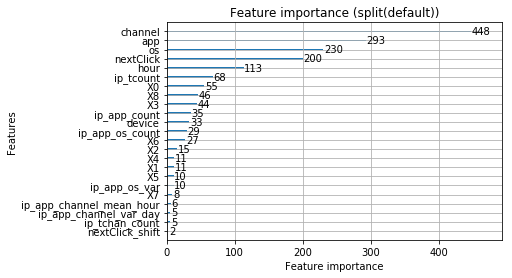

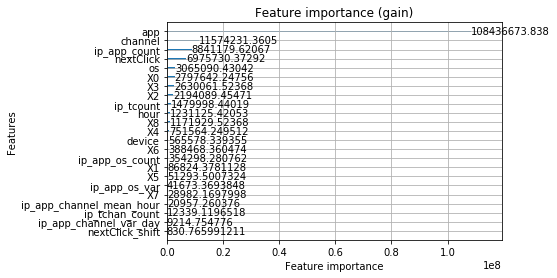

In [26]:
if WHERE!='gcloud':
    print('Plot feature importances')
    lgb.plot_importance(bst, max_num_features=100, title='Feature importance (split(default))')
    lgb.plot_importance(bst, max_num_features=100, title='Feature importance (gain)', importance_type='gain')
    plt.show()

In [27]:
print("Re-reading test data...")
test_df = pd.read_pickle('test.pkl.gz')
sub = pd.DataFrame()

print("Predicting...")
y_pred = bst.predict(test_df[predictors],num_iteration=bst.best_iteration)
outsuf = ''
if VAL_RUN:
    print(  "\n\nFULL VALIDATION SCORE:    ", 
            roc_auc_score( y_test, y_pred )  )
    print(  "PUBLIC VALIDATION SCORE:  ", 
            roc_auc_score( y_test[:public_cutoff], y_pred[:public_cutoff] )  )
    print(  "PRIVATE VALIDATION SCORE: ",
            roc_auc_score( y_test[public_cutoff:], y_pred[public_cutoff:] )  )
    outsuf = '_val'
    sub['click_id'] = pd.Series(range(len(test_df))).astype('uint32').values
else:
    sub['click_id'] = test_df['click_id'].astype('uint32').values

Re-reading test data...
Predicting...


FULL VALIDATION SCORE:     0.979040335773
PUBLIC VALIDATION SCORE:   0.975967468009
PRIVATE VALIDATION SCORE:  0.979914132843


In [30]:
public_cutoff, len(y_test), public_cutoff/len(y_test)

(4032690, 20898422, 0.19296624405421614)

In [33]:
fileno, outsuf

(4, '_val')

In [31]:
if WHERE != 'kaggle':
    os.remove('xgtrain.bin')
#os.remove('test.pkl.gz')
sub['is_attributed'] = y_pred
if not debug:
    print("\nwriting...")
    sub.to_csv('sub_it_%s'%(fileno)+outsuf+'.csv.gz', index=False, float_format='%.9f', compression='gzip')
print("\ndone...")
print( sub.head(10) )


writing...

done...
   click_id  is_attributed
0         0       0.001558
1         1       0.036643
2         2       0.014622
3         3       0.003797
4         4       0.084995
5         5       0.122013
6         6       0.051228
7         7       0.014313
8         8       0.014426
9         9       0.076432
